In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [224]:
harvard = pd.read_csv('./data/harvard_harmonized.csv', sep=";", decimal=",")
triage = pd.read_csv('./data/triage_harmonized.csv', sep=";", decimal=",")

# Correlation Analysis Harvard

In [225]:
binary_vars = harvard.columns[harvard.nunique() == 2].drop('Exacerbation')
categorical_vars = harvard.columns[(harvard.nunique() > 2) & (harvard.nunique() < 10)]
continuous_vars = harvard.columns[harvard.nunique() > 10]
print(len(binary_vars), len(categorical_vars), len(continuous_vars))

59 15 28


C:\Users\Daniel\AppData\Local\Temp\ipykernel_2508\1354438671.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[row, col].set_xticklabels(["", 'No', "", "Yes"], rotation=0)


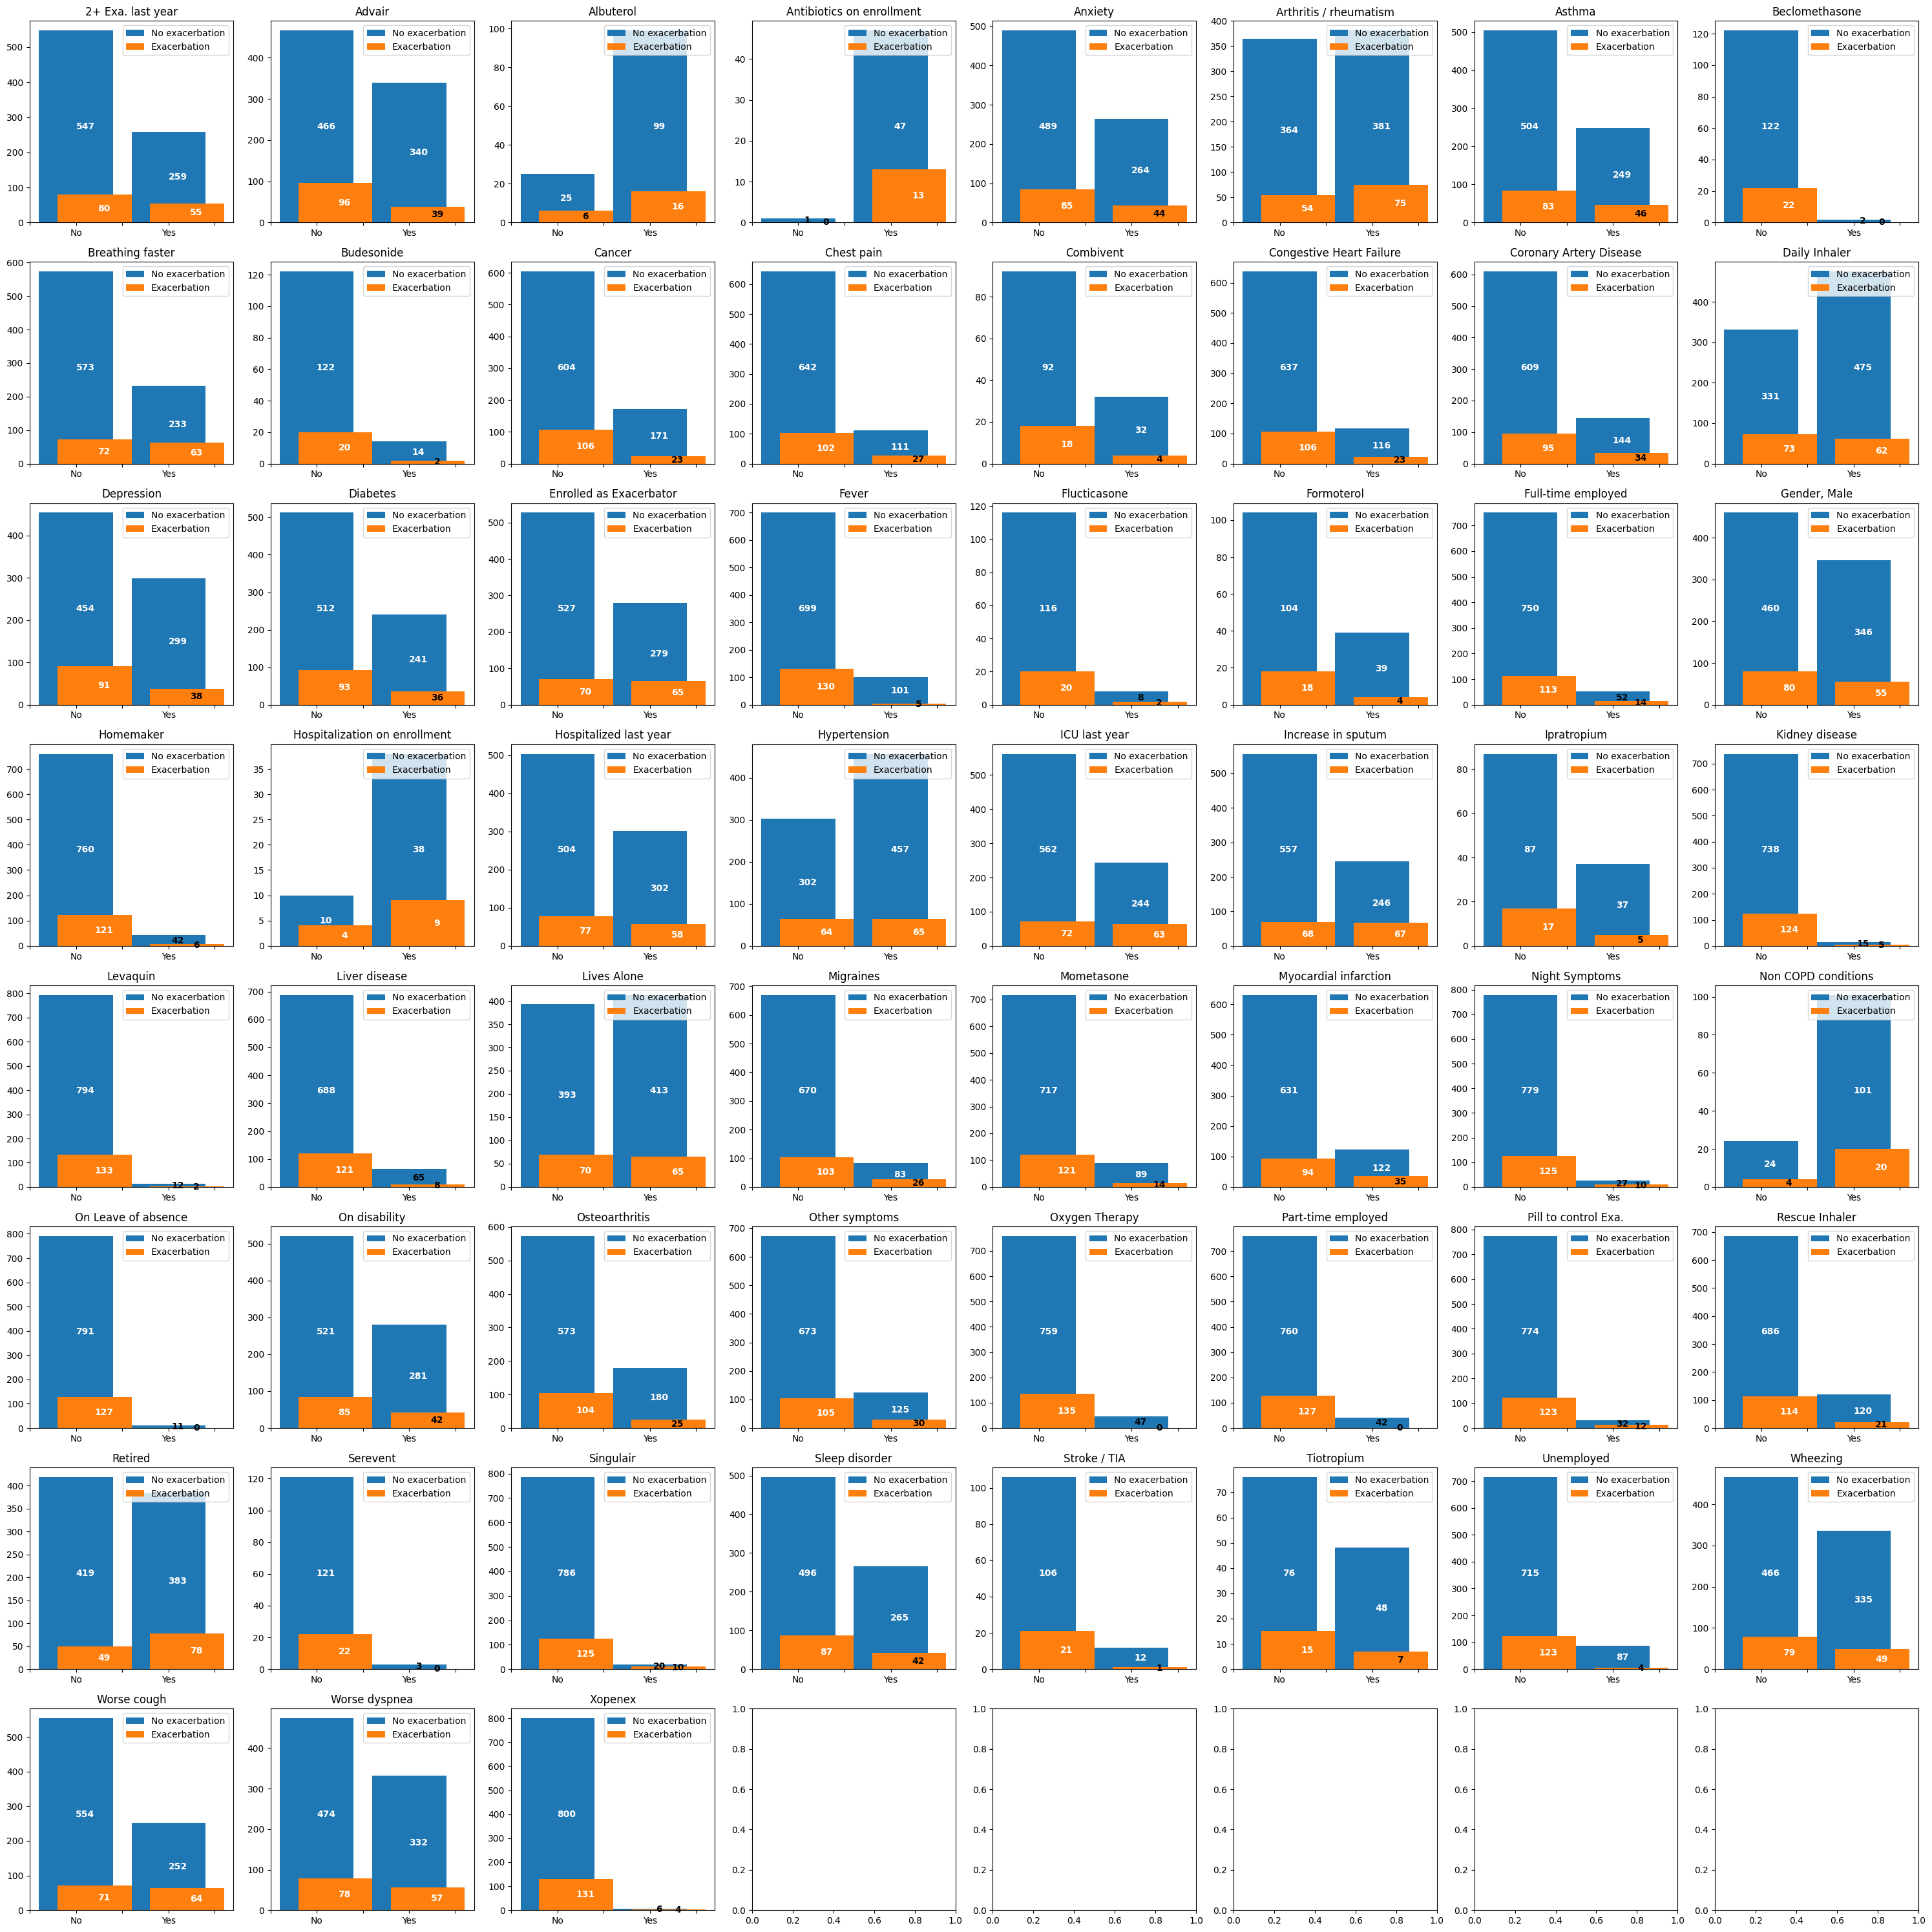

In [234]:
fig, ax = plt.subplots(8, 8, figsize=(30, 30))
col = 0
row = 0
for var in binary_vars:
    if col == 8:
        col = 0
        row += 1
    # create a 4 bar plot where exacerbation is orange and non-exacerbation blue
    exa_and_0 = harvard[(harvard['Exacerbation'] == 1) & (harvard[var] == 0)].shape[0]
    exa_and_1 = harvard[(harvard['Exacerbation'] == 1) & (harvard[var] == 1)].shape[0]
    non_exa_and_0 = harvard[(harvard['Exacerbation'] == 0) & (harvard[var] == 0)].shape[0]
    non_exa_and_1 = harvard[(harvard['Exacerbation'] == 0) & (harvard[var] == 1)].shape[0]
    
    ax[row, col].bar([0, 1], [non_exa_and_0, non_exa_and_1], color='#1f77b4', label='No exacerbation')
    # leave a gap between the bars and then the next set of bars
    ax[row, col].bar([0.2, 1.2], [exa_and_0, exa_and_1], color='#ff7f0e', label='Exacerbation')
    ax[row, col].set_title(var)
    ax[row, col].set_xticklabels(["", 'No', "", "Yes"], rotation=0)
    # add a label onto the middle of the bars

    # if the bar is larger than 10% of the plot height, write the number inside the bar
    # get the max of the 4 bars
    chart_height = np.max([non_exa_and_0, non_exa_and_1, exa_and_0, exa_and_1])

    if non_exa_and_0 > 0.1 * chart_height:
        ax[row, col].text(0.1, non_exa_and_0/2, non_exa_and_0, color='white', fontweight='bold', ha='center', va='center')
    else:
        ax[row, col].text(0.1, non_exa_and_0/2, non_exa_and_0, color='black', fontweight='bold', ha='center', va='center')
    if non_exa_and_1 > 0.1 * chart_height:
        ax[row, col].text(1.1, non_exa_and_1/2, non_exa_and_1, color='white', fontweight='bold', ha='center', va='center')
    else:
        ax[row, col].text(1.1, non_exa_and_1/2, non_exa_and_1, color='black', fontweight='bold', ha='center', va='center')
    if exa_and_0 > 0.1 * chart_height:
        ax[row, col].text(0.3, exa_and_0/2, exa_and_0, color='white', fontweight='bold', ha='center', va='center')
    else:
        ax[row, col].text(0.3, exa_and_0/2, exa_and_0, color='black', fontweight='bold', ha='center', va='center')
    if exa_and_1 > 0.1 * chart_height:
        ax[row, col].text(1.3, exa_and_1/2, exa_and_1, color='white', fontweight='bold', ha='center', va='center')
    else:
        ax[row, col].text(1.3, exa_and_1/2, exa_and_1, color='black', fontweight='bold', ha='center', va='center')
    ax[row, col].legend()
    col += 1

plt.tight_layout()
# save svg
plt.savefig('./results/binary_vars_harvard.svg', format='svg', dpi=1200)

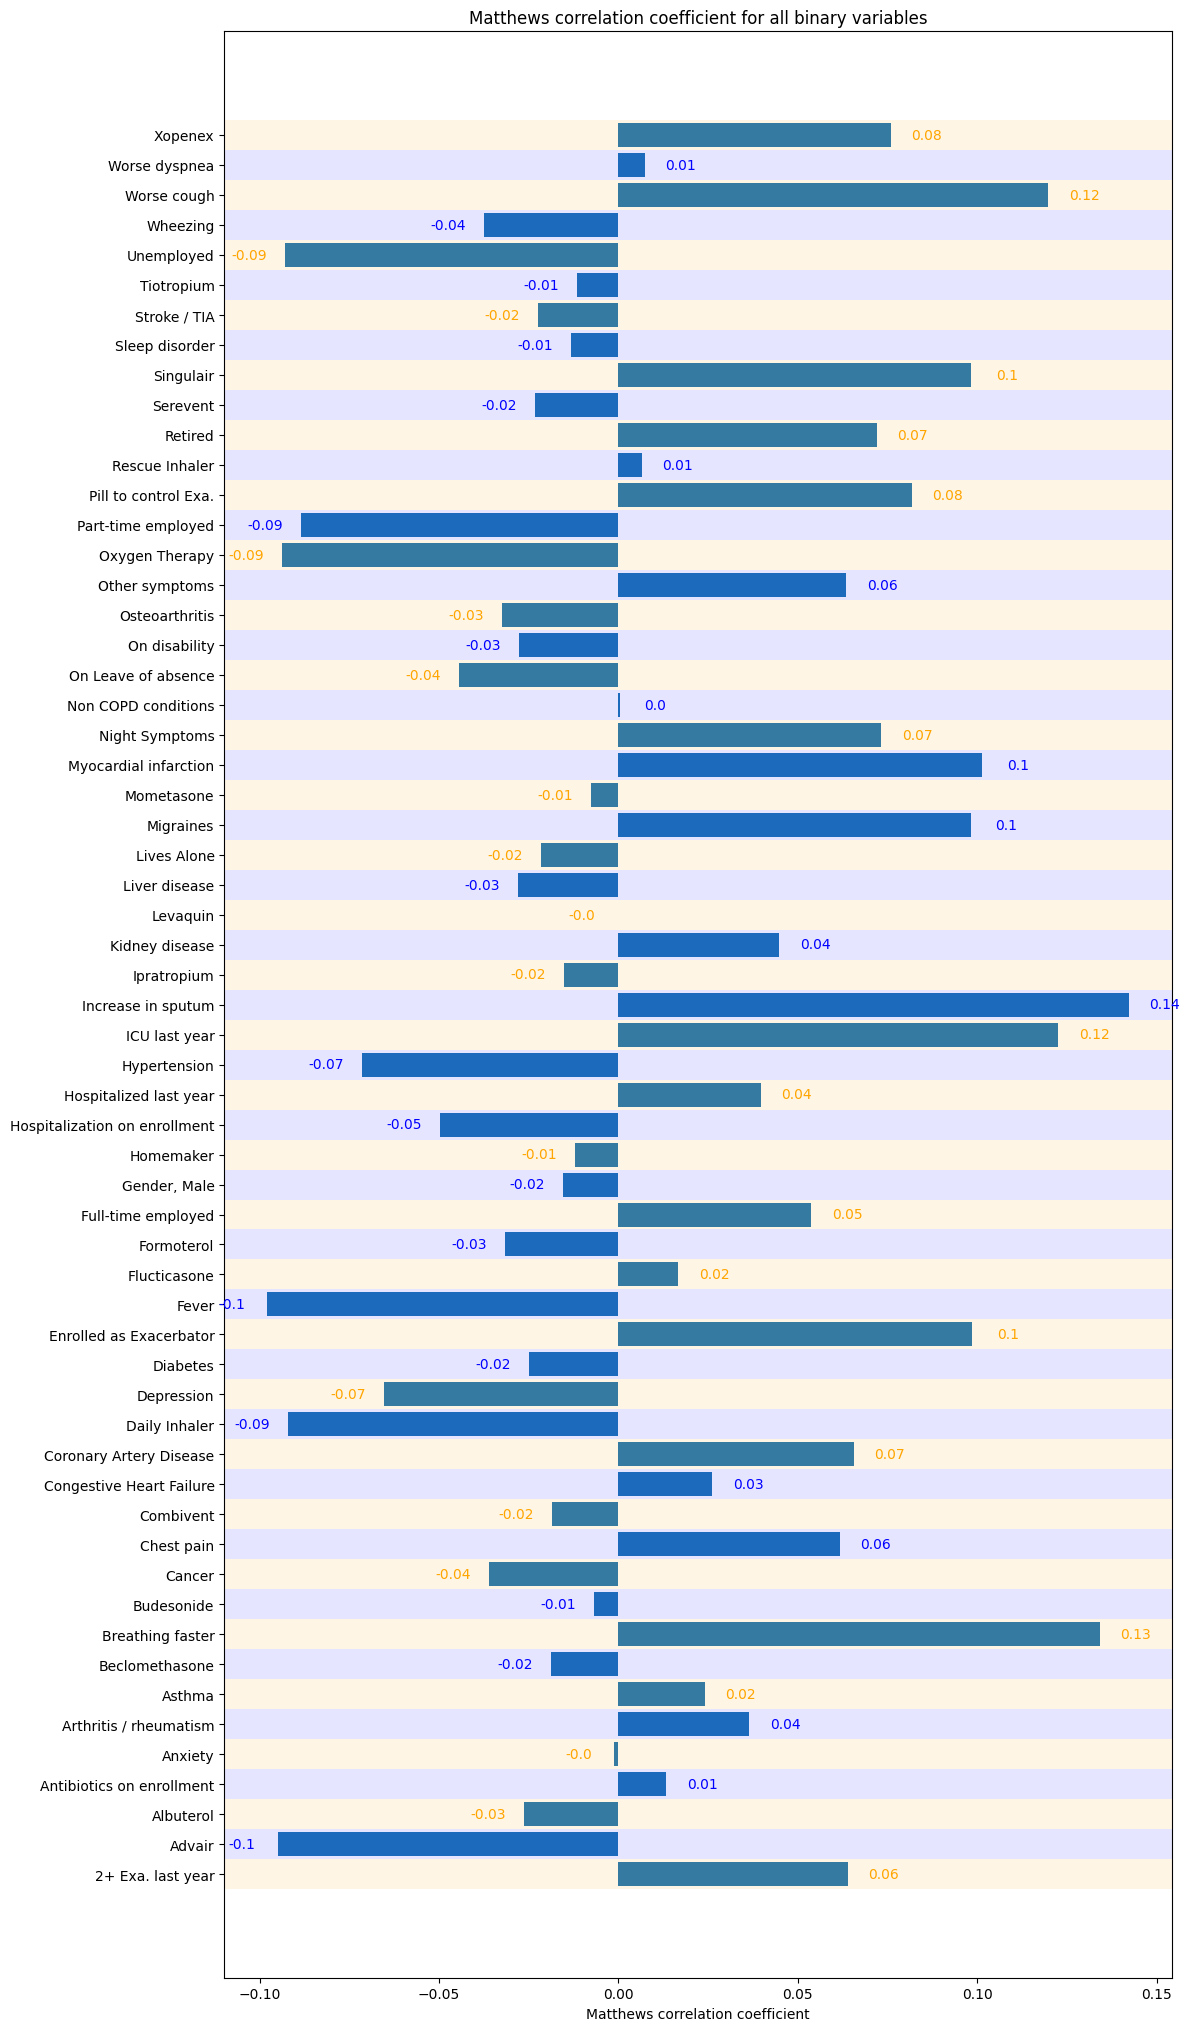

In [227]:
# calculate matthews correlation coefficient for binary variables
from sklearn.metrics import matthews_corrcoef
mcc = []
harvard_binary = harvard.copy()
harvard_binary = harvard_binary.fillna(harvard_binary.mode().iloc[0])

for var in sorted(binary_vars):
    mcc.append(matthews_corrcoef(harvard_binary[var], harvard_binary['Exacerbation']))

# plot mcc
plt.figure(figsize=(12, 20))
plt.barh(binary_vars, mcc)
# highlight the background in orange or blue for every second bar
for i in range(len(binary_vars)):
    if i % 2 == 0:
        plt.axhspan(i - 0.5, i + 0.5, facecolor='orange', alpha=0.1)
        if mcc[i] < 0:
            plt.text(mcc[i] - 0.01, i, round(mcc[i], 2), color='orange', ha='center', va='center')
        else:
            plt.text(mcc[i] + 0.01, i, round(mcc[i], 2), color='orange', ha='center', va='center')
    else:
        plt.axhspan(i - 0.5, i + 0.5, facecolor='blue', alpha=0.1)
        if mcc[i] < 0:
            plt.text(mcc[i] - 0.01, i, round(mcc[i], 2), color='blue', ha='center', va='center')
        else:
            plt.text(mcc[i] + 0.01, i, round(mcc[i], 2), color='blue', ha='center', va='center')

plt.tight_layout()
plt.title('Matthews correlation coefficient for all binary variables')
plt.xlabel('Matthews correlation coefficient')

# save as svg to results folder
plt.savefig('./results/mcc_binary.svg', format='svg')

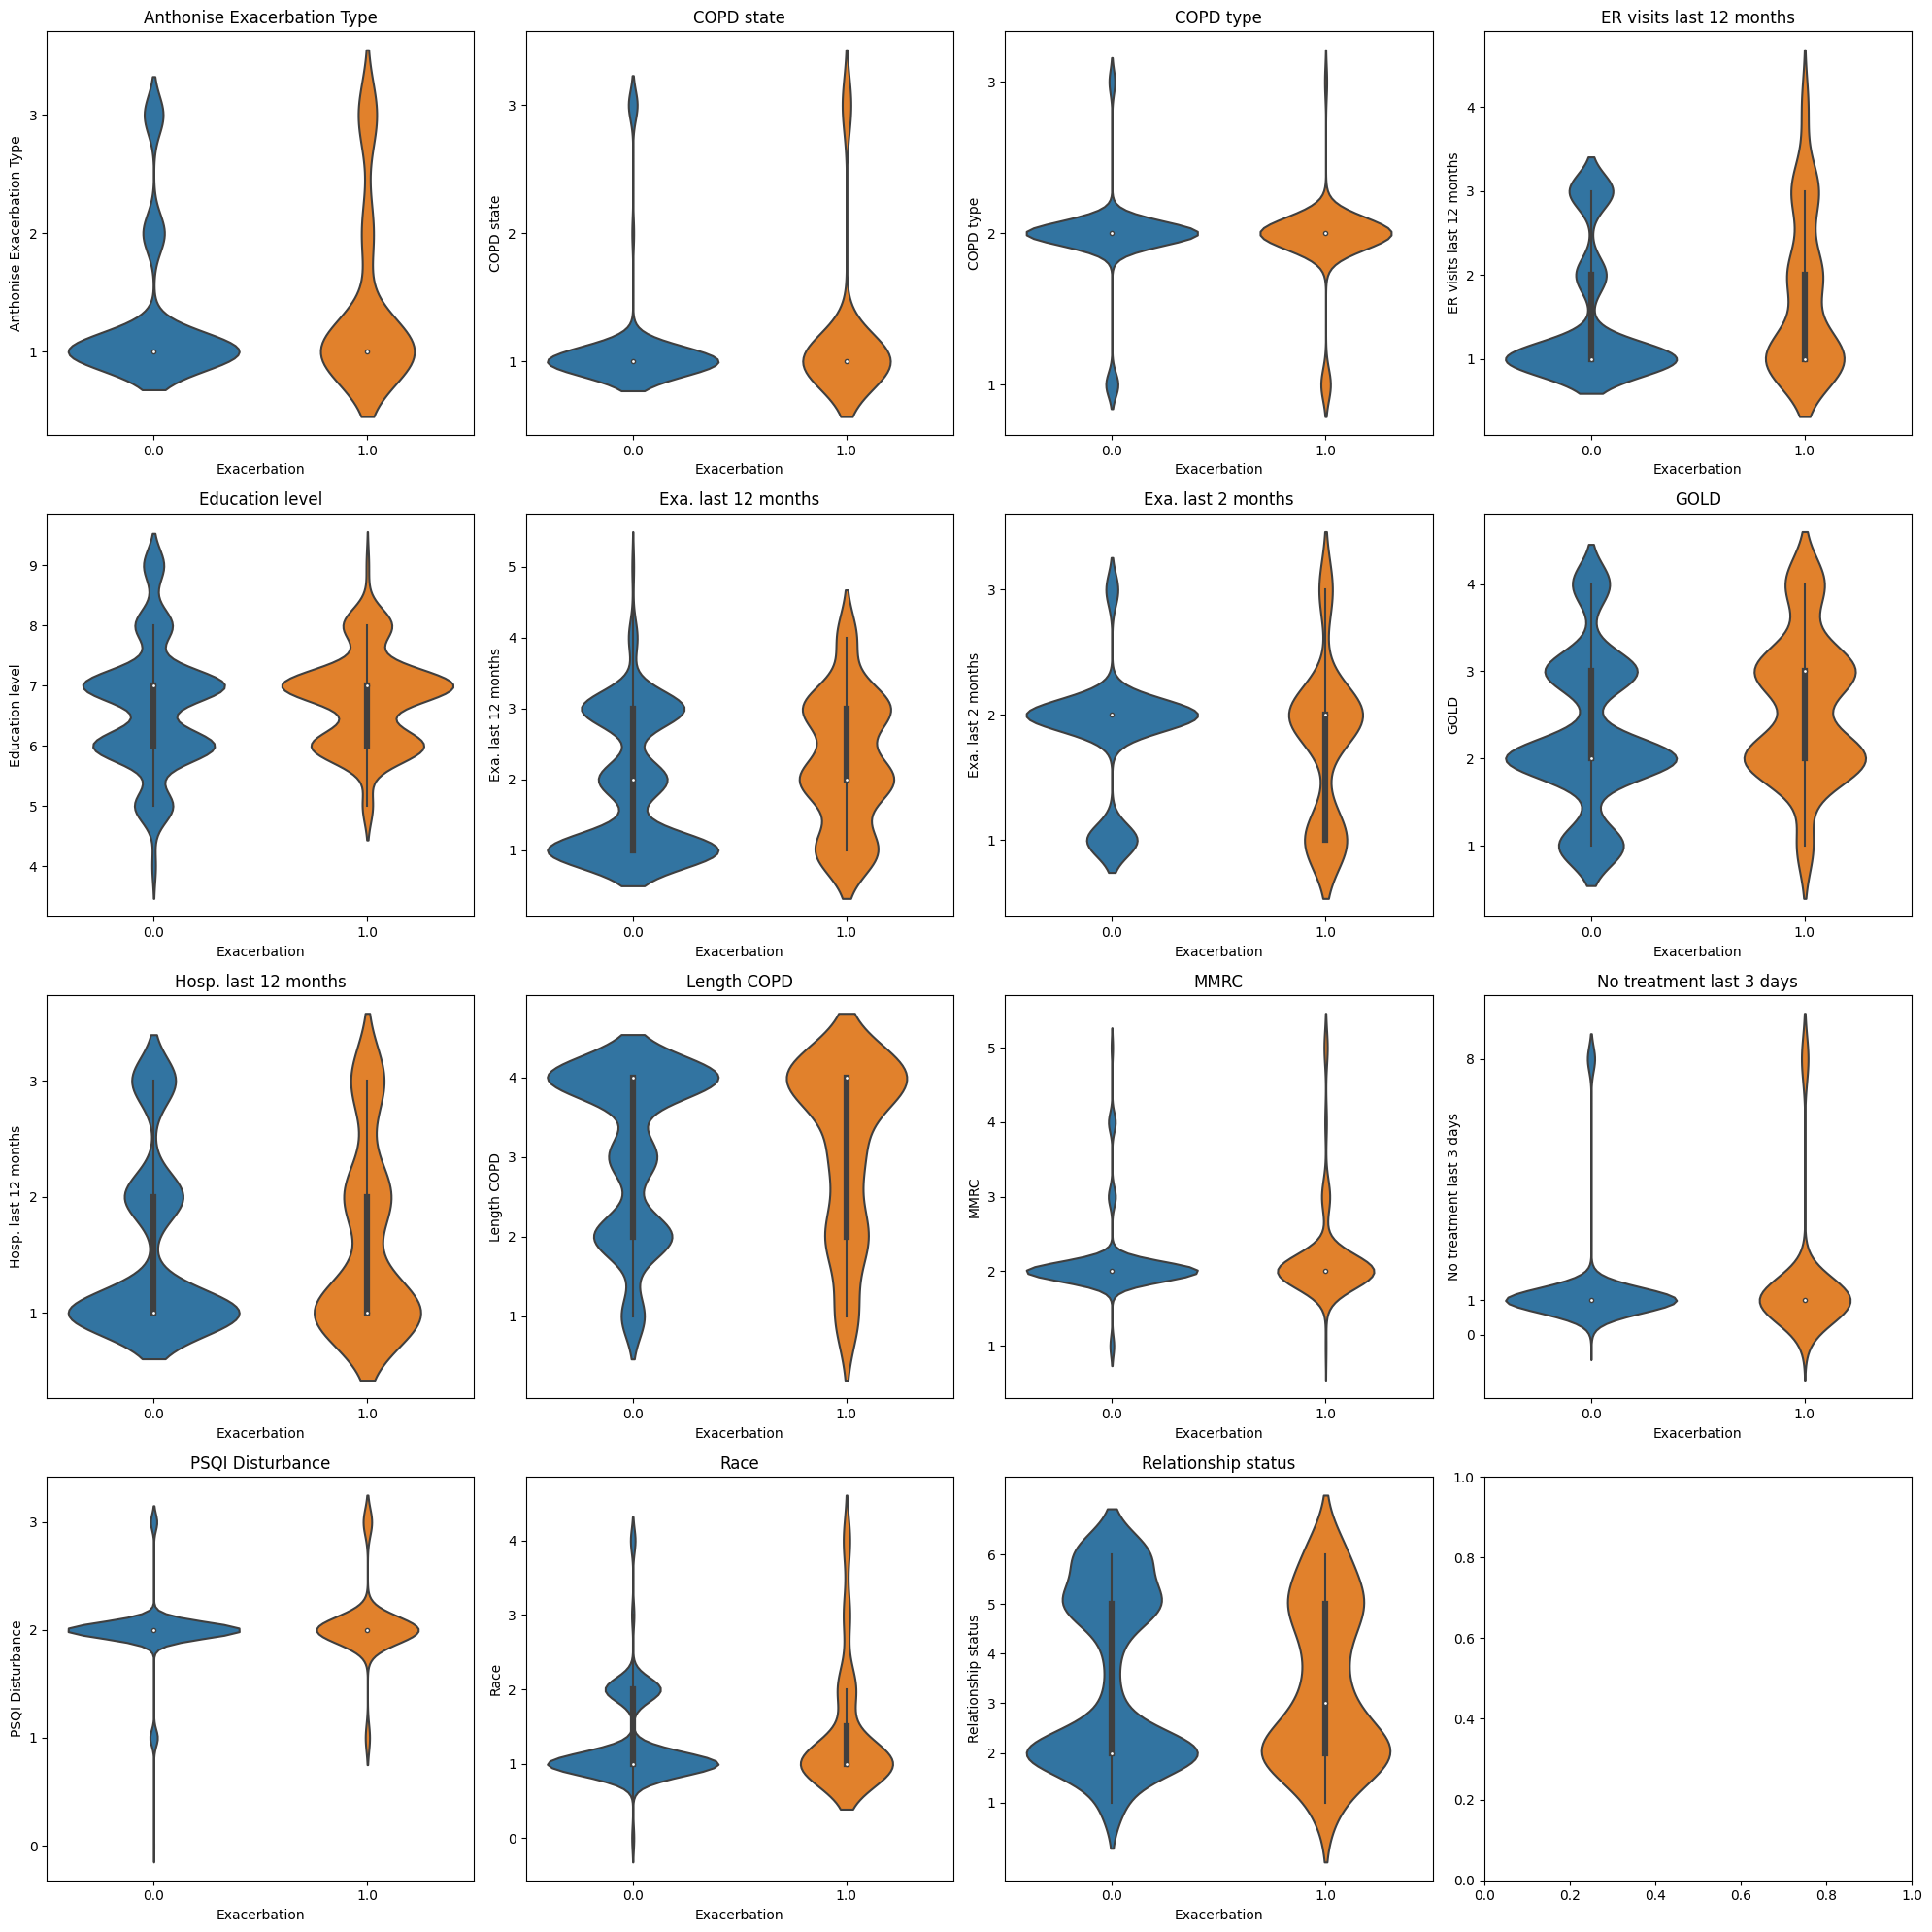

In [228]:
# plot all categorical vars vs target
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
col = 0
row = 0
harvard_viz = harvard.copy()
# drop all rows with nan values
harvard_viz[categorical_vars] = harvard_viz[categorical_vars].fillna(harvard_viz[categorical_vars].mode().iloc[0])
for var in categorical_vars:
    # do not consider nan values 
    if col == 4:
        col = 0
        row += 1
    # plot a line between mean value for exacerbation and non-exacerbation
    sns.violinplot(x='Exacerbation', y=var, data=harvard_viz, ax=axs[row, col])
    axs[row, col].set_title(var)
    axs[row, col].set_yticks(harvard_viz[var].unique())
    axs[row, col].set_ylabel(var)
    axs[row, col].set_xlabel('Exacerbation')
    col += 1

plt.tight_layout()

[0.0336997751427274, 0.09172598870736301, 0.0, 0.22498619230329595, 0.12105075553029303, 0.19453447321142434, 0.0, 0.1361464699229289, 0.0, 0.010556005932403658, 0.205901474575458, 0.14817778277021518, 0.12154266992310424, 0.1414884817822058, 0.15582673096977792]


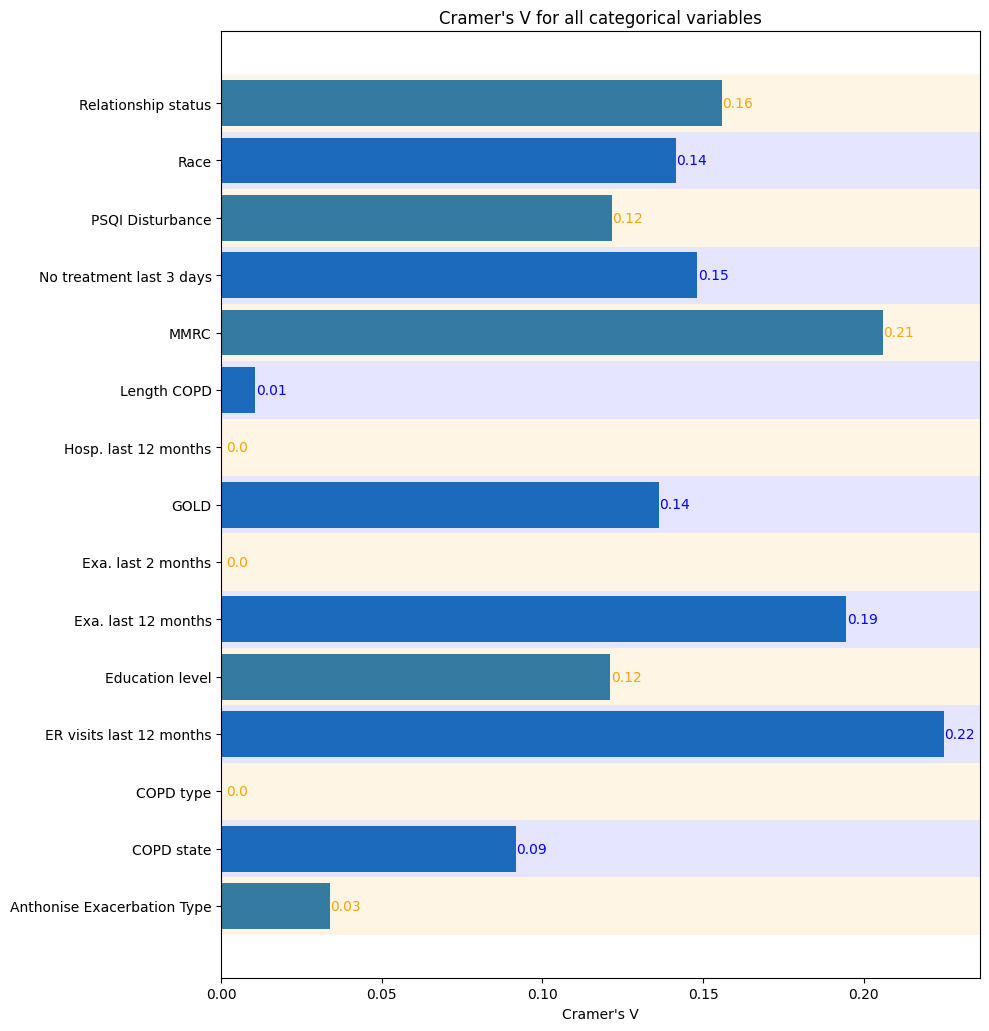

In [229]:
# calculate Cramer's V for all categorical variables
from scipy.stats import chi2_contingency

# calculate Cramer's V between the target (Exacerbation) and all categorical variables
cramers_v = []
harvard_categorical = harvard[categorical_vars].copy()
for var in categorical_vars:
    # calculate contingency table
    contingency_table = pd.crosstab(harvard_categorical[var], harvard['Exacerbation']).to_numpy()
    X2 = chi2_contingency(contingency_table, correction=False)[0]
    n = contingency_table.sum()
    phi2 = X2/n
    r,k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    cramers_v.append(np.sqrt(phi2corr / min((kcorr-1), (rcorr-1))))
print(cramers_v)

# plot Cramer's V for all categorical variables
fig, ax = plt.subplots(figsize=(10, 10))
# create barh plot with the values of cramers_v
ax.barh(categorical_vars, cramers_v)
# change color of all y ticks to blue
for i in range(len(categorical_vars)):
    if i % 2 == 0:
        ax.axhspan(i - 0.5, i + 0.5, facecolor='orange', alpha=0.1)
        ax.text(cramers_v[i] + 0.005, i, round(cramers_v[i], 2), color="orange", ha='center', va='center')
    else:
        ax.axhspan(i - 0.5, i + 0.5, facecolor='blue', alpha=0.1)
        ax.text(cramers_v[i] + 0.005, i, round(cramers_v[i], 2), color="blue",  ha='center', va='center')
plt.tight_layout()
plt.title("Cramer's V for all categorical variables")
plt.xlabel("Cramer's V")

# save as svg to results folder
plt.savefig('./results/cramers_v.svg', format='svg')

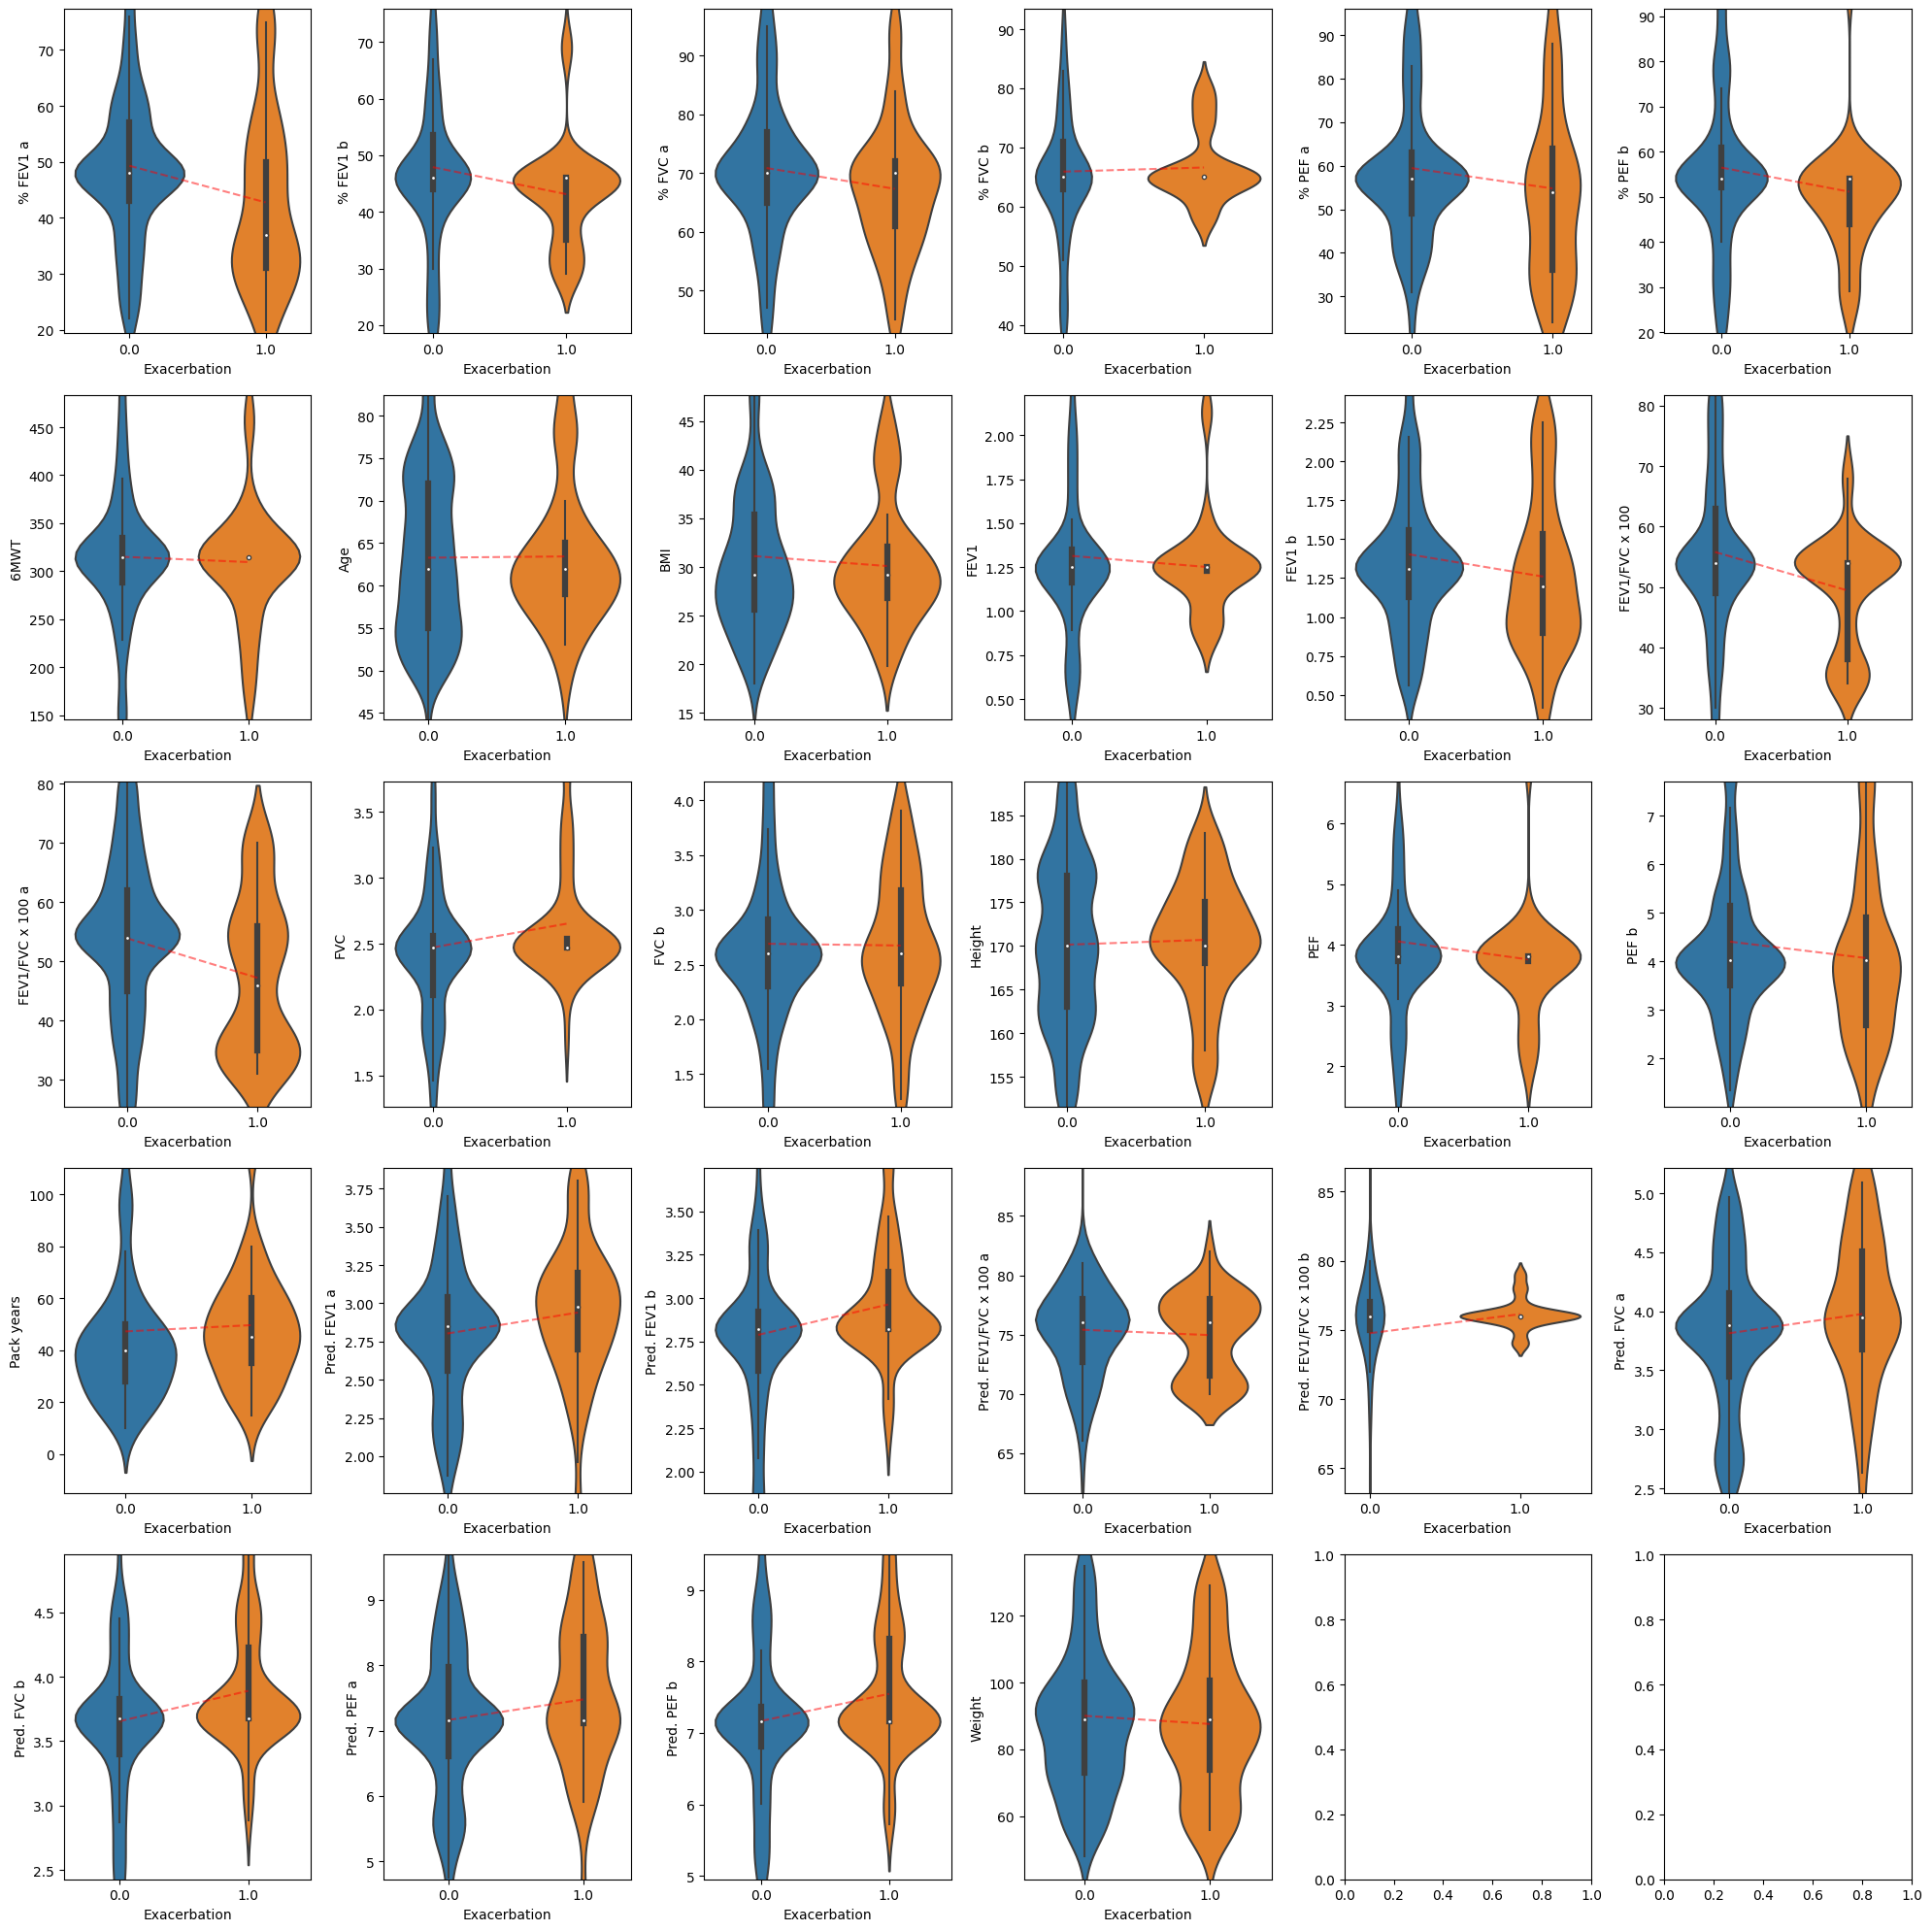

In [230]:
import seaborn as sns
# plot all continuous vars vs target
fig, axs = plt.subplots(5, 6, figsize=(20, 20))
col = 0
row = 0
harvard_viz = harvard.copy()
harvard_viz[continuous_vars] = harvard_viz[continuous_vars].fillna(harvard_viz[continuous_vars].median())
for var in continuous_vars:
    if col == 6:
        col = 0
        row += 1
    # plot a violin plot for exacerbation at x=1 and one for no exacerbation at x=0
    sns.violinplot(x='Exacerbation', y=var, data=harvard_viz, ax=axs[row, col])
    # move the y axis so that the mean value of the non-exacerbators is in the center
    axs[row, col].set_ylim(harvard_viz[var].mean() - 2 * harvard_viz[var].std(), harvard_viz[var].mean() + 2 * harvard_viz[var].std())
    # draw a line between the median values at 1 and the median values at 0
    axs[row, col].plot([0, 1], [harvard_viz[harvard_viz['Exacerbation'] == 0][var].mean(), harvard_viz[harvard_viz['Exacerbation'] == 1][var].mean()], color='red', alpha=0.5, linestyle='--')
    axs[row, col].set_xlabel('Exacerbation')
    axs[row, col].set_xticks([0, 1])
    axs[row, col].set_ylabel(var)
    col += 1

plt.tight_layout()
# save as svg to results folder
plt.savefig('./results/point_biserial_vis.svg', format='svg')

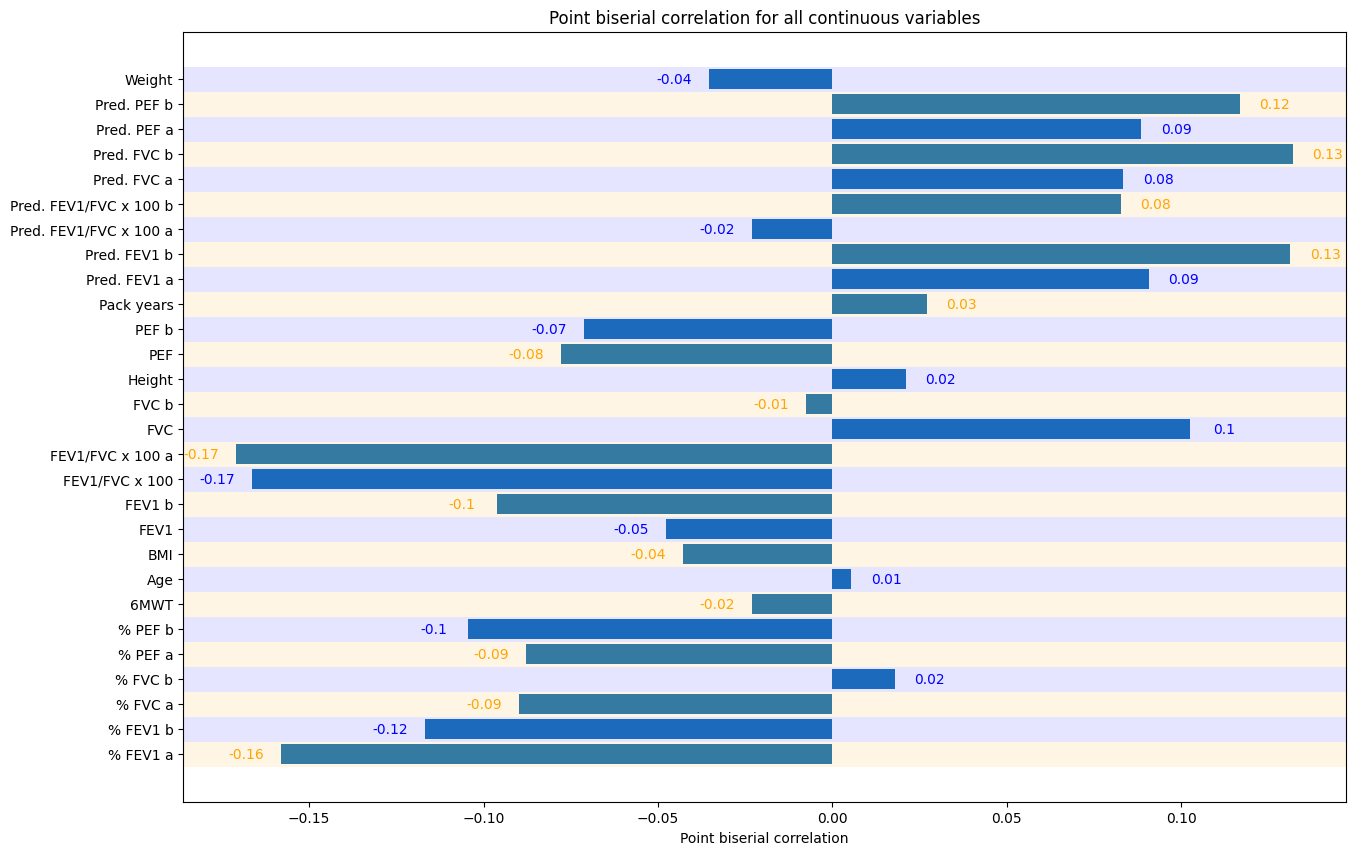

In [231]:
from scipy.stats import pointbiserialr
# calculate point biserial correlation for continuous variables
biserial_corr = []
harvard_continuous = harvard[continuous_vars].copy()
for var in continuous_vars:
    # drop all rows with nan values
    harvard_continuous[var] = harvard_continuous[var].fillna(harvard_continuous[var].median())
    # calculate point biserial correlation
    biserial_corr.append(pointbiserialr(harvard_continuous[var], harvard['Exacerbation'])[0])

# plot point biserial correlation for all continuous variables
plt.figure(figsize=(15, 10))
# color all the plots in every second row to make it easier to read
plt.barh(continuous_vars, biserial_corr)
    
# color the y ticks in every second row to make it easier to read
for i in range(len(continuous_vars)):
    if i % 2 == 0:
        plt.axhspan(i - 0.5, i + 0.5, facecolor='orange', alpha=0.1)
        if biserial_corr[i] > 0:
            plt.text(biserial_corr[i] + 0.01, i, round(biserial_corr[i], 2), ha='center', va='center', color='orange')
        else:
            plt.text(biserial_corr[i] - 0.01, i, round(biserial_corr[i], 2),  ha='center', va='center', color='orange')
    else:
        plt.axhspan(i - 0.5, i + 0.5, facecolor='blue', alpha=0.1)
        if biserial_corr[i] > 0:
            plt.text(biserial_corr[i] + 0.01, i, round(biserial_corr[i], 2), ha='center', va='center', color='blue')
        else:
            plt.text(biserial_corr[i] - 0.01, i, round(biserial_corr[i], 2),  ha='center', va='center', color='blue')
plt.title('Point biserial correlation for all continuous variables')
    
plt.xlabel('Point biserial correlation')
# save as svg to results folder
plt.savefig('./results/point_biserial.svg', format='svg')

# Descriptive Statistics

In [232]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

# binary columns are variables with only 2 values
binary_cols = harvard.columns[harvard.nunique() == 2]
count_dataframe = pd.DataFrame(columns=['Exacerbation', 'No Exacerbation', 'Effect size'])
# add row n with the count of exacerbations
exa_count = harvard['Exacerbation'][harvard['Exacerbation'] == 1].count()
no_exa_count = harvard['Exacerbation'][harvard['Exacerbation'] == 0].count()
count_dataframe.loc['n'] = exa_count, no_exa_count, ""
for var in binary_cols:
    # the Exacerbation column is all values where fclinra08 is 1 and the value in col is the positive value
    exa_col_count = [harvard['Exacerbation'][harvard['Exacerbation'] == 1][harvard[var] == 1].count()]
    exa_percentage = round(exa_col_count[0] / exa_count * 100, 2)
    exa_col_string = str(exa_col_count[0]) + ' (' + str(exa_percentage) + '%)'
    no_exa_col_count = [harvard['Exacerbation'][harvard['Exacerbation'] == 0][harvard[var] == 1].count()]
    no_exa_percentage = round(no_exa_col_count[0] / no_exa_count * 100, 2)
    no_exa_col_string = str(no_exa_col_count[0]) + ' (' + str(no_exa_percentage) + '%)'
    # fit a logistic model to calculate the odds ratio
    X = harvard[var].fillna(harvard[var].median()).values.reshape(-1, 1)
    y = harvard['Exacerbation']
    y = LabelEncoder().fit_transform(y)
    model = LogisticRegression(random_state=42).fit(X, y)
    odds_ratio = np.exp(model.coef_[0])
    # confidence interval
    # Calculate the standard error of the coefficient
    standard_error = np.sqrt(np.diag(model.coef_))[0]
    # Calculate the z-score for the desired confidence level (e.g., 95%)
    confidence_level = 0.95
    z = norm.ppf(1 - (1 - confidence_level) / 2)
    # Calculate the confidence interval
    lower_bound = odds_ratio * np.exp(-z * standard_error)
    upper_bound = odds_ratio * np.exp(z * standard_error)
    # create a string for the odds ratio and confidence interval
    odds_ratio_string = str(round(odds_ratio[0], 2)) + ' (' + str(round(lower_bound[0], 2)) + '-' + str(round(upper_bound[0], 2)) + ')'

    # add the counts to the dataframe
    count_dataframe.loc[var] = exa_col_string, no_exa_col_string, odds_ratio_string

# sort by effect size
count_dataframe.sort_values(by='Effect size', ascending=False, inplace=True)

# get the percentage (value between brackets and before %)
# count_dataframe['Exa_perc'] = count_dataframe['Exacerbation'].str.split('(', expand=True)[1]
# count_dataframe['Exa_perc'] = count_dataframe['Exa_perc'].str.split('%', expand=True)[0]

# count_dataframe['No_exa_perc'] = count_dataframe['No Exacerbation'].str.split('(', expand=True)[1]
# count_dataframe['No_exa_perc'] = count_dataframe['No_exa_perc'].str.split('%', expand=True)[0]
# # convert to float
# count_dataframe['Exa_perc'] = count_dataframe['Exa_perc'].astype(float)
# count_dataframe['No_exa_perc'] = count_dataframe['No_exa_perc'].astype(float)

# # find values with the highest difference in percentage
# count_dataframe['Difference'] = abs(count_dataframe['Exa_perc'] - count_dataframe['No_exa_perc'])
# count_dataframe.sort_values(by='Difference', ascending=False, inplace=True)
# count_dataframe.drop(['Difference', 'Exa_perc', 'No_exa_perc'], axis=1, inplace=True)

# now look at numeric variables
numeric_cols = harvard.columns[harvard.nunique() > 2]
mean_dataframe = pd.DataFrame(columns=['Exacerbation', 'No Exacerbation', 'Effect size'])
for var in numeric_cols:
    positives = harvard[var][harvard['Exacerbation'] == 1]
    negatives = harvard[var][harvard['Exacerbation'] == 0]
    # get the mean + std for the exacerbation group with only 2 decimal places
    exacerbation_mean = round([positives.mean()][0], 2)
    exacerbation_std = round([positives.std()][0], 2)
    # create a string for the mean +- std
    exacerbation_string = str(exacerbation_mean) + u"(" + str(exacerbation_std) +")"
    # get the mean + std for the no exacerbation group
    no_exacerbation_mean = round([negatives.mean()][0], 2)
    no_exacerbation_std = round([negatives.std()][0], 2)
    # create a string for the mean +- std
    no_exacerbation_string = str(no_exacerbation_mean) + u"(" + str(no_exacerbation_std) +")"
    std_exa = harvard[var][harvard['Exacerbation'] == 1].std()
    # effect size 1 (Glass's delta) with Exacerbation group variance that we want to emphasize
    effect_size = np.round((exacerbation_mean - no_exacerbation_mean) / std_exa, 2)

    # add the strings to the dataframe
    mean_dataframe.loc[var] = exacerbation_string, no_exacerbation_string, effect_size

# print the largest effect size
print(mean_dataframe['Effect size'].abs().sort_values(ascending=False).head(10))

# sort by the largest absolute effect size
# create an abs column
mean_dataframe['abs'] = abs(mean_dataframe['Effect size'])
mean_dataframe.sort_values(by='abs', ascending=False, inplace=True)
mean_dataframe.drop(['abs'], axis=1, inplace=True)

# set effectsize column to str
mean_dataframe['Effect size'] = mean_dataframe['Effect size'].astype(str)

# concat both dataframes
descriptive_stats = pd.concat([count_dataframe, mean_dataframe], axis=0)


# export to csv
descriptive_stats.to_csv('.\harvard_descriptive_stats_2.csv', sep=';', decimal=',', encoding='utf-8')



# harvard_statistics = harvard.copy()
# harvard_statistics.fillna(harvard_statistics.median(), inplace=True)
# y = harvard_statistics['Exacerbation']
# y = LabelEncoder().fit_transform(y)
# X = harvard_statistics.drop(['Exacerbation'], axis=1)
# model = LogisticRegression(random_state=42)
# model.fit(X, y)
# odds_ratios = np.exp(model.coef_[0])
# # turn into 1D array
# odds_ratios
# odds_ratios_df = pd.DataFrame({'Variable': X.columns, 'Odds Ratio': odds_ratios})
# odds_ratios_df.sort_values(by='Odds Ratio', ascending=False, inplace=True)
# for row in odds_ratios_df.iterrows():
#     print(row[1]['Variable'], row[1]['Odds Ratio'])


# params = res.params
# conf = res.conf_int()
# conf['Odds Ratio'] = params
# conf.columns = ['5%', '95%', 'Odds Ratio']
# print(np.exp(conf))


# OddsRatio = pd.DataFrame(columns=['Variable', 'OddsRatio', 'CI95', 'Pvalue'])
# # calculate the Odds ratio for each variable
# for var in harvard_statistics.columns:
#     # drop na values
#     harvard_statistics = harvard_statistics.dropna(subset=[var])
#     # fit a logistic regression model
#     clf = LogisticRegression(random_state=42)
#     clf.fit(harvard_statistics[var].values.reshape(-1, 1), harvard_statistics[Exacerbation])
#     OR = np.exp(clf.coef_)
#     # calculate the confidence interval
#     CI = np.exp(clf.coef_ + 1.96 * clf.coef_ * np.sqrt((1 - clf.coef_) / harvard_statistics[var].shape[0]))

C:\Users\Daniel\AppData\Local\Temp\ipykernel_2508\2133482200.py:28: RuntimeWarning: invalid value encountered in sqrt
  standard_error = np.sqrt(np.diag(model.coef_))[0]
C:\Users\Daniel\AppData\Local\Temp\ipykernel_2508\2133482200.py:28: RuntimeWarning: invalid value encountered in sqrt
  standard_error = np.sqrt(np.diag(model.coef_))[0]
C:\Users\Daniel\AppData\Local\Temp\ipykernel_2508\2133482200.py:28: RuntimeWarning: invalid value encountered in sqrt
  standard_error = np.sqrt(np.diag(model.coef_))[0]
C:\Users\Daniel\AppData\Local\Temp\ipykernel_2508\2133482200.py:28: RuntimeWarning: invalid value encountered in sqrt
  standard_error = np.sqrt(np.diag(model.coef_))[0]
C:\Users\Daniel\AppData\Local\Temp\ipykernel_2508\2133482200.py:28: RuntimeWarning: invalid value encountered in sqrt
  standard_error = np.sqrt(np.diag(model.coef_))[0]
C:\Users\Daniel\AppData\Local\Temp\ipykernel_2508\2133482200.py:28: RuntimeWarning: invalid value encountered in sqrt
  standard_error = np.sqrt(np.di

Pred. FEV1/FVC x 100 b    1.39
FEV1/FVC x 100            1.11
Pred. FEV1 b              0.86
Pred. FVC b               0.85
% FEV1 b                  0.75
Pred. PEF b               0.73
FVC                       0.67
FEV1/FVC x 100 a          0.56
% FEV1 a                  0.48
% PEF b                   0.48
Name: Effect size, dtype: float64


C:\Users\Daniel\AppData\Local\Temp\ipykernel_2508\2133482200.py:28: RuntimeWarning: invalid value encountered in sqrt
  standard_error = np.sqrt(np.diag(model.coef_))[0]
C:\Users\Daniel\AppData\Local\Temp\ipykernel_2508\2133482200.py:28: RuntimeWarning: invalid value encountered in sqrt
  standard_error = np.sqrt(np.diag(model.coef_))[0]
C:\Users\Daniel\AppData\Local\Temp\ipykernel_2508\2133482200.py:28: RuntimeWarning: invalid value encountered in sqrt
  standard_error = np.sqrt(np.diag(model.coef_))[0]
C:\Users\Daniel\AppData\Local\Temp\ipykernel_2508\2133482200.py:28: RuntimeWarning: invalid value encountered in sqrt
  standard_error = np.sqrt(np.diag(model.coef_))[0]
C:\Users\Daniel\AppData\Local\Temp\ipykernel_2508\2133482200.py:28: RuntimeWarning: invalid value encountered in sqrt
  standard_error = np.sqrt(np.diag(model.coef_))[0]


PermissionError: [Errno 13] Permission denied: '.\\harvard_descriptive_stats_2.csv'